In [1]:
import cantera as ct    # import cantera
import math             # import math (sqrt, exp, etc.)
from scipy.integrate import solve_ivp  # solves ODE (initial value problems)
import scipy.integrate as integrate
import matplotlib.pyplot as plt      # does matlab-like plotting
import numpy as np                    # does a bunch of array stuff

In [2]:
gas = ct.Solution('chem.cti')

A list of all the reaction equations can be listed with the 

``` python
reaction_equations()
```

function.

### Reaction Rates Constants

The forward and reverse rate constants for all reactions be accessed with 
```python
   .forward_rate_constants
   .reverse_rate_constants
```
arrays.  Both of these are arrays return the rate constant for each reaction on a **molar** basis.  The precise units are dependent on the overrall order of the reaction.  The order of the list corresponds to the order in the full reaction equation list.

In [3]:
gas.forward_rate_constants

array([2.82683727e-01, 1.17842545e+10, 5.44691431e+03, ...,
       5.51956920e-06, 1.33780253e-13, 9.51785220e-14])

A rate constant for specific reaction in the array can be accessed with the particular element.  

In [4]:
kf=gas.forward_rate_constants[11]
kr=gas.reverse_rate_constants[11]
print('for ', gas.reaction_equation(11), ': kf = ', kf, 'kr = ', kr)

for  2 O + M => O2 + M : kf =  14458845.803240841 kr =  0.0


### Reaction Rates of Progress

the forward, reverse, and net rate of progress on a **molar** basis for all reactions can be accessed by the arrays: 

```python
forward_rates_of_progress
reverse_rates_of_progress
net_rates_of_progress
```
The units are *always* kmol/m$^3$ s. 

In [5]:
gas.TPX = 1500, 101325, {'CO2':1}
RRf = gas.forward_rates_of_progress[11]
RRr = gas.reverse_rates_of_progress[11]
RRn = gas.net_rates_of_progress[11]

print('for ', gas.reaction_equation(11), ': RRf = ', RRf, 
      'RRr = ', RRr, 'RR net = ', RRn, ' kmol/m^3 s')

for  2 O + M => O2 + M : RRf =  0.0 RRr =  0.0 RR net =  0.0  kmol/m^3 s


### Molar Rates Production

The molar rates of production for each species can be accessed by the following arrays: 

```python
creation_rates
destruction_rates
net_production_rates
```  
The units are always on a **molar** basis with *kmol/m$^3$ s*. 


The full array of each net production rate for each species is 

The production rate for a particular species can be accessed using its species index. 

In [6]:
nCO2 = gas.species_index('CO2')
cRate = gas.creation_rates[nCO2]
dRate = gas.destruction_rates[nCO2]
pRate = gas.net_production_rates[nCO2]

print('The CO2 rate of creation, destruction, and net production are', cRate, dRate, pRate, 'kmol/m^3 s')

The CO2 rate of creation, destruction, and net production are 0.0 6.421485882566368e-09 -6.421485882566368e-09 kmol/m^3 s


The mass production rate for each species can be computed via:

$\dot{\omega}_i = \overline{\dot{\omega}}_i MW_i$

In [7]:
MW_CO2 = gas.molecular_weights[nCO2]
omegaBar_CO2 = gas.net_production_rates[nCO2]

print('The net mass production rate of CO2 is', MW_CO2*omegaBar_CO2, 'kg/m$^3$ s')

The net mass production rate of CO2 is -2.826031722058633e-07 kg/m$^3$ s


Lets equilibrate the mixture and ensure that the net molar rates of production are effectively zero. 

In [8]:
gas.equilibrate('HP')
#print(gas.net_production_rates)


## Constant Volume Adiabatic Reactor

In class we will show that the differential equations describing the evolution of species mass fractions and temperature for constant volume adiabatic reactor are:

$\frac{d Y_i}{dt} =\frac{\dot{\omega_i}}{\rho}, \ \ \ i = 1, \cdots N$

$\frac{d T}{dt} = \frac{- \sum u_i \dot{\omega}_i}{\rho Cv_{\text{mix}}}$

These equations will be integrated using the stiff ODE solver from Python and Cantera to evaluate the net rate of production for each species, internal energies for each species, and the mixture specific heat.  An issue to be aware of is that Cantera returns the species rate of production only on a molar basis.  However, 

$\overline{u}_i = u_i MW_i; \ \ \ \overline{\dot{\omega}}_i = \dot{\omega}_i/MW_i$,

Thus

$ u_i \dot{\omega}_i = \overline{u}_i \overline{\dot{\omega}}_i$,

and the temperature and mass fraction equations that we will actually solve is

$\frac{d T}{dt} = \frac{- \sum \overline{u}_i \overline{\dot{\omega}}_i}{\rho Cv_{\text{mix}}}$

$\frac{d Y_i}{dt} =\frac{\overline{\dot{\omega}_i} MW_i}{\rho}, \ \ \ i = 1, \cdots N$

To solve the system of ODEs for the constant volume reactor, we first must define a function that computes the time derivatives for the mass fractions and temperature.  (The below function looks long, but most of the lines are comments. There are only 13 active lines of code.)

## 3.2 - Constant volume reactant code

In [9]:
def CV_Reactor_RHS(t,y,gas,density):
    # t = time
    # y = the solution vector: y[0] = temperature, y[1:nSpecies] = mass fractions
    
    dy = np.zeros(np.size(y)) # initialize the RHS vector
    
    
    # get T and Y_i from the solution vector.
    # T is the first (0) index of the solution array y[0]
    # all indexes after 0, y[1:], are the mass fractions
    T = y[0];
    massFrac = y[1:];

    # Now we set the species composition.  Here we use a special version that 
    # does not normalize the mass fractions to sum to unity.  Solving systems
    # of ODEs like this are one of the few cases where you do not want
    # to normalize the mass fractions.  
    
    # Swagnik, in case you get a question: This has to do with computing the
    # Jacobian using finite differences.  If Y_i were normalized than perturbing one
    # will perturb all of the others, which messes up the Jacobian computation. 
    gas.set_unnormalized_mass_fractions(massFrac)
    
    # set the state using the density (density is constant for this case, 
    # but pressure is not.  So we have to set the thermodynamic state using 
    # the temperature and density. )
    gas.TD=T, density #gas.density_mass
    

    

    # Now that the thermodynamic state is set, we can compute the chemical
    # rate of production, species internal energies, cv, etc. 
    wdot = gas.net_production_rates      # get the species MOLAR production rate
    mws  = gas.molecular_weights         # get the species MW_i
    ui = gas.partial_molar_int_energies  # get the species internal energy on a MOLAR basis
    cv = gas.cv_mass                     # get the mixture CV on a MASS basis
        
    # form the RHS for a CV adiabatic reactor
    dTdt = -np.sum(wdot*ui)/(density*cv)   # the sum function sums elements over an array
                                           # you don't need the .* as in Matlab
    dYdt = wdot*mws/density
    
    # stuff the temperature and mass fraction time derivatives into an array
    dy[0 ] = dTdt
    dy[1:] = dYdt
    
    return dy

For convenience, we will define a function that integrates the CV reactor.  Similar to the equilibrate function, the initial conditions are set based on the gas state that is an input to the function

In [10]:
def integrate_CV_reactor(gas, tEnd,atol=1.e-10, rtol=1.e-8):
    rho = gas.density_mass # compute the density on a mass basis

    # set the initial conditions for the reactor
    y =  np.zeros(gas.n_species+1) 
    y[0] = gas.T
    y[1:] = gas.Y

    # solve the ODEs for the CV reactor.  This is equivalent to ode15s in Matlab.
    soln = integrate.solve_ivp(fun=lambda t, y: CV_Reactor_RHS(t,y,gas,rho), 
                               t_span=[0,tEnd],y0=y,method='BDF',rtol=rtol,atol=atol);
    return soln

In [11]:
def P_heat_release_CV_Reactor(soln, gas):
    # Compute the pressure and rate of heat release based on the solution
    # to a CV reactor
    
    # find the number of time points and pre-allocate an array
    npt = len(soln.t)
    p_hr = np.zeros((2,npt))
    
    # loop over over each time, set the gas composition and compute the pressure.  
    for i in range(npt):
        # set the gas composition.  Note: the y[1:,i] grabs all elements in the array after 1
        gas.TDY = soln.y[0,i], gas.density_mass, soln.y[1:,i] 
        p = gas.P # compute the pressure
        
        # compute the chemical heat release rate
        hr = -np.sum(gas.net_production_rates*gas.partial_molar_int_energies)
        
        # store the pressure and heat release rate
        p_hr[0,i] = p
        p_hr[1,i] = hr
        
    return p_hr

def compute_CV_ignition_delay(gas,soln, tShift = 600.):
    # compute the ignition delay time from the solution to a CV reactor.  
    # this is (crudely) based on the time when the temperatur increases 
    # by a specified value from the initial reactant temperature
    npt = len(soln.t)    
    tInit = soln.y[0,0]
    
    for i in range(npt):
        if (soln.y[0,i] > tInit + tShift):
            break
            
    t_ign = soln.t[i]
    
    return t_ign

## 3.2 a) 


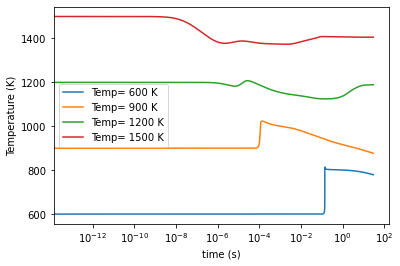

In [12]:
# Ignition delay time 
# Set the pressure and temp 

p_init = 101325*40
temp_start= 600
temp_end= 1500

# temparature array 
npts = 31

tInit = np.linspace(temp_start, temp_end,npts)
tIgn = np.zeros(npts)

for i in range(npts):
    #print(i)
    # The initial conditions are based on the gas state.
    #gas.TPX = tInit[i], p_init, {'NC7H16':0,'IC8H18':1, 'O2':0.3} #PRF 0
    gas.TPX = tInit[i], p_init, {'NC7H16':0.5,'IC8H18':0.5, 'O2':0.3} #PRF 50
    #gas.TPX = tInit[i], p_init, {'NC7H16':1,'IC8H18':0, 'O2':0.3} #PRF 100


# now integrate the ODEs
    soln = integrate_CV_reactor(gas, 30.)

    if (i%5 == 0):
        plt.semilogx(soln.t,soln.y[0,:],label='Temp= %d K'%tInit[i])
    
    tIgn[i] = compute_CV_ignition_delay(gas,soln, tShift = 50.)

plt.xlabel('time (s)')
plt.ylabel('Temperature (K)')
plt.legend()
plt.show()

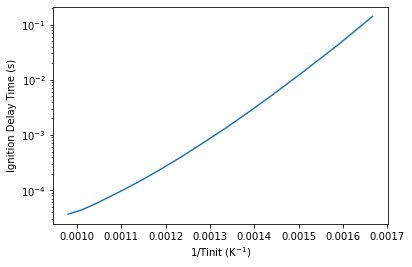

In [13]:
plt.semilogy(1./tInit[0:15],tIgn[0:15])
plt.xlabel('1/Tinit (K$^{-1}$)')
plt.ylabel('Ignition Delay Time (s)')
plt.show()

## 3.2 b)

C:\Users\riasat\.conda\envs\combustion\lib\site-packages\scipy\integrate\_ivp\bdf.py:403: RuntimeWarning: invalid value encountered in subtract
  D[order + 2] = d - D[order + 1]


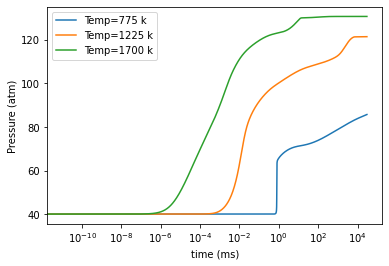

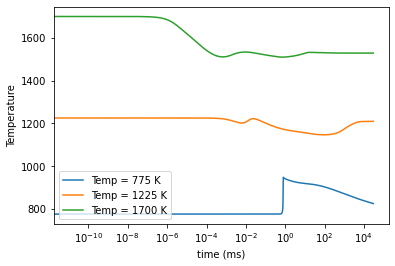

In [14]:
t_range=[775,1225,1700]

fig1,ax1=plt.subplots()
fig2,ax2=plt.subplots()
for i in t_range:
    gas.TPX = i, p_init, {'NC7H16':0.5,'IC8H18':0.5, 'O2':0.3} #PRF 50
    soln = integrate_CV_reactor(gas,30.)
    p_hr = P_heat_release_CV_Reactor(soln,gas) 
    ax1.semilogx(soln.t*1000, p_hr[0,:]/101325,label='Temp=%d k'%i)
    ax2.semilogx(soln.t*1000,soln.y[0,:],label='Temp = %d K'%i)
    
    
#plt.xlim(100, 200)
ax1.set_xlabel('time (ms)')
ax1.set_ylabel('Pressure (atm)')
ax1.legend()


ax2.set_xlabel('time (ms)')
ax2.set_ylabel('Temperature')
ax2.legend()
plt.show()

The cell below defines integers that access selected variables in the solution array from that CV reactor solution.  A variable can be accessed by:  

```python 
soln.y[variable_index, time_index]
```

The time can be accessed by:

```python
soln.t[time_index]
```

All of the times can be accessed using the colon operator (similar to matlab)

```python
soln.t[:]
soln.y[variable_index,:]
   ```

The variable indexes are:

| variable index | variable |
| --- | --- |
| 0 | Temperature |
| 1 | Species 0 |
| 2 | Species 1 |
| 3 | Species 2 |
| ... | ... |
| N+1 | Species N |

the variable index for a particular species can be found by:

```python
species_variable_index = gas.species_index(species_name) + 1
    ```
    
Below we define some variable indices for plotting the solution.

## 3.2 c)

In [15]:
temp_index = 0
gas.TPX = 600, p_init, {'NC7H16':0.5,'IC8H18':0.5, 'O2':0.3} #PRF 50
soln = integrate_CV_reactor(gas,30.)

H2O2_index = gas.species_index('H2O2') + 1
CH3_index = gas.species_index('CH3') + 1
H_index = gas.species_index('H') + 1
OH_index = gas.species_index('OH') + 1 
CO_index = gas.species_index('CO') + 1
H2O_index = gas.species_index('H2O') + 1
CO2_index = gas.species_index('CO2') + 1
O2_index = gas.species_index('O2') + 1
nHeptane_index = gas.species_index('NC7H16')+1
isoOctane_index = gas.species_index('IC8H18')+1

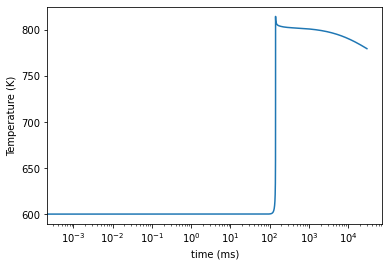

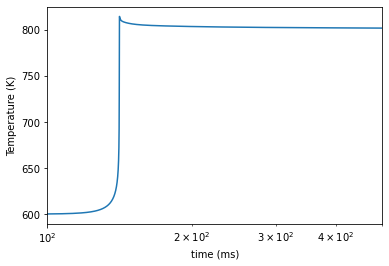

In [16]:
# Now plot the solution.  Note: Cantera works in SI units, but I convert to ms in the line below. 
plt.semilogx(soln.t*1000, soln.y[temp_index,:])
plt.xlabel('time (ms)')
plt.ylabel('Temperature (K)')
plt.show()


# The first plot isn't very useful... even on a semilogx-scale... Lets zoom in to where the action is. 
plt.semilogx(soln.t*1000, soln.y[temp_index,:])
plt.xlim(100, 500)
plt.xlabel('time (ms)')
plt.ylabel('Temperature (K)')
plt.show()

    


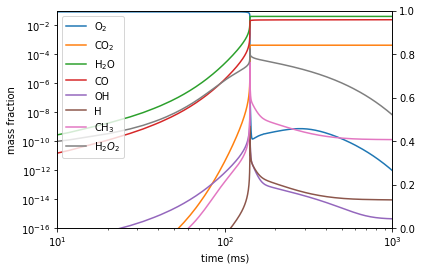

In [17]:
fig3,ax3 = plt.subplots()
ax4=ax3.twinx()
ax3.loglog(soln.t*1000, soln.y[O2_index,:],  label = 'O$_2$')
ax3.loglog(soln.t*1000, soln.y[CO2_index,:], label = 'CO$_2$')
ax3.loglog(soln.t*1000, soln.y[H2O_index,:], label = 'H$_2$O')
ax3.loglog(soln.t*1000, soln.y[CO_index,:], label = 'CO')
ax3.loglog(soln.t*1000,soln.y[OH_index,:], label = 'OH')
ax3.loglog(soln.t*1000, soln.y[H_index,:], label = 'H')
ax3.loglog(soln.t*1000, soln.y[CH3_index,:], label = 'CH$_3$')
ax3.loglog(soln.t*1000, soln.y[H2O2_index,:], label = 'H$_2O_2$')

#ax3.loglog(soln.t*1000, soln.y[nHeptane_index,:], label = 'n-$C_7H_{16}$')
# For annotating the plot, please use either a legend or annotatations
#ax3.legend(loc="best", bbox_to_anchor=[.9, .5],
#           ncol=1, shadow=True,  fancybox=True,fontsize='medium')
ax3.set_xlim([10,1000])
ax3.set_ylim(1.E-16, 0.1)
ax3.set_xlabel('time (ms)')
ax3.set_ylabel('mass fraction')
ax3.legend()
plt.show()

## 3.2 d)

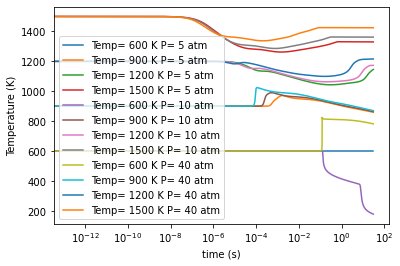

In [18]:
# Ignition delay time 
# Set the pressure and temp 

p_atm=101325
p_range = [p_atm*5,p_atm*10,p_atm*40]
temp_start= 600
temp_end= 1500

# temparature array 
npts = 31

tInit = np.linspace(temp_start, temp_end,npts)
tIgn = np.zeros((len(p_range),npts))

for j in range(len(p_range)):
    for i in range(npts):
        gas.TPX = tInit[i], p_range[j], {'NC7H16':1,'IC8H18':0, 'O2':0.3} #PRF 100
        # now integrate the ODEs
        soln = integrate_CV_reactor(gas, 30.)
        
        if (i%10 == 0):
            plt.semilogx(soln.t,soln.y[0,:],label='Temp= %d K P= %d atm'%(tInit[i],p_range[j]/101325))

        tIgn[j][i] = compute_CV_ignition_delay(gas,soln, tShift = 50.)
        
plt.xlabel('time (s)')
plt.ylabel('Temperature (K)')
plt.legend()
plt.show()

## 3.2 e)

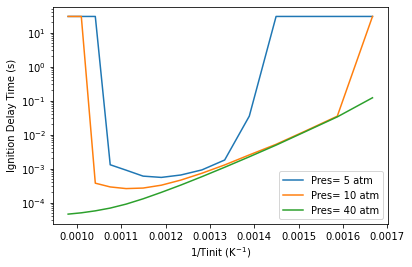

In [19]:

for j in range(len(p_range)):
    plt.semilogy(1./tInit[0:15],tIgn[j][0:15], label='Pres= %d atm'%(p_range[j]/101325))
    

plt.xlabel('1/Tinit (K$^{-1}$)')
plt.ylabel('Ignition Delay Time (s)')    
plt.legend()
plt.show()